In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
pip install mxnet-cu112 wget leven

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 499.4 MB 1.6 kB/s 
     |████████████████████████████████| 154 kB 61.5 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=9aa920ba9d257e460d428295e8a6f708670563142eb70bea9e535dfd4dd7115c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
  Created wheel for leven: filename=leven-1.0.4-cp37-cp37m-linux_x86_64.whl size=55495 sha256=d31433e27cfe80403133399076e76c191444686114f976edb28d44aed1fd7f2a
  Stored in directory: /root/.cache/pip/wheels/27/d5/b1/b36dd23f85aa662f19b11ef6069d5dc66643dfc1831d9f2bf5
Successfully built wget leven
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import math
import os
import time
import wget
import random
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.gluon.data import ArrayDataset, DataLoader
import string
import tarfile
import urllib
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import cv2
import numpy as np
import _pickle as cPickle
import re
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import pickle
from leven import levenshtein
import glob
import matplotlib.gridspec as gridspec
%matplotlib inline

# Hand-writing detection using CNN + biLSTM + CTC-loss


OCR using MXNet Gluon. The pipeline is composed of a CNN + biLSTM + CTC. The dataset is from: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database. You need to register and get a username and password from their website.

In [5]:
DESIRED_SIZE = (32,128)
IMAGES_DATA_FILE = 'images_data.pkl'

In [6]:
if os.path.isfile(IMAGES_DATA_FILE):
    images_data = pickle.load(open(IMAGES_DATA_FILE, 'rb'))
else:
    images_data = None

In [7]:
!mkdir handwritting

## Data Preprocessing

In [8]:
def pre_processing(img_in):    
    im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
    size = im.shape[:2] # old_size is in (height, width) format
    if size[0] > DESIRED_SIZE[0] or size[1] > DESIRED_SIZE[1]:
        ratio_w = float(DESIRED_SIZE[0])/size[0]
        ratio_h = float(DESIRED_SIZE[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        im = cv2.resize(im, (new_size[1], new_size[0]))
        size = im.shape

    delta_w = max(0, DESIRED_SIZE[1] - size[1])
    delta_h = max(0, DESIRED_SIZE[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    color = im[0][0]
    if color < 230:
        color = 230
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    img_arr = np.asarray(new_im)
    return img_arr

## Data Download

In [9]:
cd /content/handwritting

/content/handwritting


In [10]:
!tar zxvf /content/drive/MyDrive/iam/words.tgz

Streaming output truncated to the last 5000 lines.
r06/r06-137/r06-137-05-08.png
r06/r06-137/r06-137-05-09.png
r06/r06-137/r06-137-05-10.png
r06/r06-137/r06-137-05-11.png
r06/r06-137/r06-137-06-00.png
r06/r06-137/r06-137-06-01.png
r06/r06-137/r06-137-06-02.png
r06/r06-137/r06-137-06-03.png
r06/r06-137/r06-137-06-04.png
r06/r06-137/r06-137-06-05.png
r06/r06-137/r06-137-06-06.png
r06/r06-137/r06-137-06-07.png
r06/r06-137/r06-137-06-08.png
r06/r06-137/r06-137-07-00.png
r06/r06-137/r06-137-07-01.png
r06/r06-137/r06-137-07-02.png
r06/r06-137/r06-137-07-03.png
r06/r06-137/r06-137-07-04.png
r06/r06-137/r06-137-07-05.png
r06/r06-137/r06-137-07-06.png
r06/r06-137/r06-137-07-07.png
r06/r06-137/r06-137-07-08.png
r06/r06-137/r06-137-07-09.png
r06/r06-137/r06-137-07-10.png
r06/r06-137/r06-137-07-11.png
r06/r06-137/r06-137-07-12.png
r06/r06-137/r06-137-08-00.png
r06/r06-137/r06-137-08-01.png
r06/r06-137/r06-137-08-02.png
r06/r06-137/r06-137-08-03.png
r06/r06-137/r06-137-08-04.png
r06/r06-137/r06-137

In [11]:
!tar zxvf /content/drive/MyDrive/iam/xml.tgz

./
a01-000u.xml
a01-000x.xml
a01-003.xml
a01-003u.xml
a01-003x.xml
a01-007.xml
a01-007u.xml
a01-007x.xml
a01-011.xml
a01-011u.xml
a01-011x.xml
a01-014.xml
a01-014u.xml
a01-014x.xml
a01-020.xml
a01-020u.xml
a01-020x.xml
a01-026.xml
a01-026u.xml
a01-026x.xml
a01-030.xml
a01-030u.xml
a01-030x.xml
a01-038.xml
a01-038x.xml
a01-043.xml
a01-043u.xml
a01-043x.xml
a01-049.xml
a01-049u.xml
a01-049x.xml
a01-053.xml
a01-053u.xml
a01-053x.xml
a01-058.xml
a01-058u.xml
a01-058x.xml
a01-063.xml
a01-063u.xml
a01-063x.xml
a01-068u.xml
a01-072u.xml
a01-072x.xml
a01-077.xml
a01-077u.xml
a01-082u.xml
a01-087.xml
a01-087u.xml
a01-091.xml
a01-091u.xml
a01-096u.xml
a01-102.xml
a01-102u.xml
a01-107.xml
a01-107u.xml
a01-113.xml
a01-113u.xml
a01-117.xml
a01-117u.xml
a01-122.xml
a01-122u.xml
a01-128.xml
a01-128u.xml
a01-132.xml
a01-132u.xml
a01-132x.xml
a02-000.xml
a02-004.xml
a02-008.xml
a02-012.xml
a02-017.xml
a02-020.xml
a02-024.xml
a02-027.xml
a02-032.xml
a02-037.xml
a02-042.xml
a02-046.xml
a02-050.xml
a02-05

## Data Loading

In [12]:
cd

/root


In [13]:
%%time
if images_data is None:
    error_count = 0
    images_data = dict()
    image_files = glob.glob("/content/handwritting/**/*.png", recursive=True)
    for filepath in image_files:
        try:
            processed_img = pre_processing(filepath)                
            images_data[filepath.split('/')[-1].split('.')[0]] = [processed_img]
        except:
            error_count += 1


    xml_files = glob.glob('/content/handwritting/**/*.xml', recursive=True)
    for filepath in xml_files:
        tree = ET.parse(filepath)
        root = tree.getroot()
        for word in root.iter('word'):
            if word.attrib['id'] in images_data:
                images_data[word.attrib['id']].append(word.attrib['text'])

    print("{} images successfully loaded, {} errors".format(len(images_data), error_count))
    images_data = [(images_data[key][0], images_data[key][1]) for key in images_data]
    pickle.dump(images_data, open(IMAGES_DATA_FILE, 'wb'))

115318 images successfully loaded, 2 errors
CPU times: user 41.2 s, sys: 4.27 s, total: 45.4 s
Wall time: 46.5 s


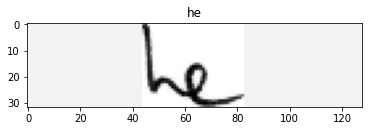

In [14]:
for i in range(10):
    n = int(random.random()*len(images_data))
    ax = plt.imshow(images_data[n][0], cmap='Greys_r')
    plt.title(images_data[n][1])
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

## Data Set creation

In [15]:
SEQ_LEN = 32
ALPHABET = string.ascii_letters+string.digits+string.punctuation+' '
ALPHABET_INDEX = {ALPHABET[i]:i for i in range(len(ALPHABET))}
ALPHABET_SIZE = len(ALPHABET)+1
BATCH_SIZE = 64
print(ALPHABET)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [16]:
random.shuffle(images_data)
split = 0.8
images_data_train = images_data[:int(split*len(images_data))]
images_data_test = images_data[int(split*len(images_data)):]

In [17]:
def transform(image, label):
    image = np.expand_dims(image, axis=0).astype(np.float32)/255.
    label_encoded = np.zeros(SEQ_LEN, dtype=np.float32)-1
    for i, letter in enumerate(label):
        if i >= SEQ_LEN:
            break
        label_encoded[i] = ALPHABET_INDEX[letter]
    
    return image, label_encoded

In [18]:
dataset_train = ArrayDataset(images_data_train).transform(transform)
dataset_test = ArrayDataset(images_data_test).transform(transform)

In [19]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, last_batch='discard', shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, last_batch='discard', shuffle=True)

## Model Creation

In [20]:
NUM_HIDDEN = 200
NUM_CLASSES = 13550
NUM_LSTM_LAYER = 1
p_dropout = 0.5

Compute context

In [21]:
ctx = mx.gpu()

In [22]:
ctx

gpu(0)

### Featurizer layer
We use a CNN to featurize the input data

In [23]:
def get_featurizer():
    featurizer = gluon.nn.HybridSequential()
    # conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.BatchNorm())
    
    # second conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    #third conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.BatchNorm())
    featurizer.add(gluon.nn.Dropout(p_dropout))
    
    #fourth layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.BatchNorm())
    featurizer.hybridize()
    return featurizer

### Encoder layer
The LSTM will take the data in temporal order (left to right), SEQ_LEN slices and will encoded them

We define a custom layer that is going to:
- reshape the data from (N, W, H) to (SEQ_LEN, N, CHANNELS)
- run the biDirectional LSTM
- reshape the data from (SEQ_LEN, N, HIDDEN_UNITS) to (N, SEQ_LEN, HIDDEN_UNITS)

In [24]:
class EncoderLayer(gluon.Block):
    def __init__(self, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(NUM_HIDDEN, NUM_LSTM_LAYER, bidirectional=True)
    def forward(self, x):
        x = x.transpose((0,3,1,2))
        x = x.flatten()
        x = x.split(num_outputs=SEQ_LEN, axis = 1) # (SEQ_LEN, N, CHANNELS)
        x = nd.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) # (N, SEQ_LEN, HIDDEN_UNITS)
        return x

In [25]:
def get_encoder():
    encoder = gluon.nn.Sequential()
    encoder.add(EncoderLayer())
    encoder.add(gluon.nn.Dropout(p_dropout))
    return encoder

### Decoder layer
The resulting encoded slices will be fed to a fully connected layer of size ALPHABET_SIZE and the result will be fed to a CTC loss

In [26]:
def get_decoder():
    decoder = mx.gluon.nn.Dense(units=ALPHABET_SIZE, flatten=False)
    decoder.hybridize()
    return decoder

### Loss

In [27]:
ctc_loss = gluon.loss.CTCLoss(weight=0.2)

### Net Assembly

In [28]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(get_featurizer())
        net.add(get_encoder())
        net.add(get_decoder())
    return net
net = get_net()

### Parameters initialization

In [29]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

### Trainer

In [30]:
LEARNING_RATE = 0.00005
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })

### Evaluation loop

In [31]:
# This decodes the predictions and the labels back to words
def decode(prediction):
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(ALPHABET) or index == -1:
                continue
            else:
                result.append(ALPHABET[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

We use a metric based on the levenshtein distance. This measure what is the number of operations we would need to apply to the prediction in % of the total length of the label

In [32]:
def metric_levenshtein(predictions, labels):
    predictions = predictions.softmax().topk(axis=2).asnumpy()
    zipped = zip(decode(labels.asnumpy()), decode(predictions))
    metric = sum([(len(label)-levenshtein(label, pred))/len(label) for label, pred in zipped])
    return metric/len(labels)

In [33]:
def evaluate_accuracy(net, dataloader):
    metric = 0
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        metric += metric_levenshtein(output, label)
    return metric/(i+1)

In [34]:
%%time
evaluate_accuracy(net, dataloader_test)

CPU times: user 14.2 s, sys: 768 ms, total: 15 s
Wall time: 16 s


-1.4541478056632966

### Training loop

In [35]:
epochs = 20
print_n = 250

for e in range(epochs):    
    loss = nd.zeros(1, ctx)
    tick = time.time()
    acc = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)

        with autograd.record():
            output = net(data)
            loss_ctc = ctc_loss(output, label)
            loss_ctc = (label != -1).sum(axis=1)*loss_ctc
        loss_ctc.backward()
        loss += loss_ctc.mean()
        
        trainer.step(data.shape[0])
            
        if i%print_n == 0 and i > 0:
            print('Batches {0}: CTC Loss: {1:.2f}, time:{2:.2f} s'.format(
                i, float(loss.asscalar()/print_n), time.time()-tick))
            loss = nd.zeros(1, ctx)
            tick = time.time()
            nd.waitall()
    validation_accuracy = evaluate_accuracy(net, dataloader_test)
    print("Epoch {0}, Val_acc {1:.2f}".format(e, validation_accuracy))

Batches 250: CTC Loss: 25.57, time:7.42 s
Batches 500: CTC Loss: 16.35, time:6.40 s
Batches 750: CTC Loss: 15.93, time:6.40 s
Batches 1000: CTC Loss: 15.62, time:6.52 s
Batches 1250: CTC Loss: 15.02, time:7.20 s
Epoch 0, Val_acc 0.04
Batches 250: CTC Loss: 14.99, time:6.58 s
Batches 500: CTC Loss: 14.61, time:6.46 s
Batches 750: CTC Loss: 14.50, time:6.53 s
Batches 1000: CTC Loss: 14.14, time:6.46 s
Batches 1250: CTC Loss: 14.08, time:6.48 s
Epoch 1, Val_acc 0.12
Batches 250: CTC Loss: 13.73, time:6.90 s
Batches 500: CTC Loss: 13.46, time:6.52 s
Batches 750: CTC Loss: 13.51, time:6.54 s
Batches 1000: CTC Loss: 13.09, time:6.58 s
Batches 1250: CTC Loss: 13.12, time:6.60 s
Epoch 2, Val_acc 0.22
Batches 250: CTC Loss: 13.35, time:6.62 s
Batches 500: CTC Loss: 12.71, time:6.53 s
Batches 750: CTC Loss: 12.76, time:6.66 s
Batches 1000: CTC Loss: 12.48, time:6.71 s
Batches 1250: CTC Loss: 12.59, time:7.28 s
Epoch 3, Val_acc 0.13
Batches 250: CTC Loss: 12.40, time:6.74 s
Batches 500: CTC Loss:

## Saving/Loading

In [36]:
a = nd.array([1,2,3])

In [37]:
a*a


[1. 4. 9.]
<NDArray 3 @cpu(0)>

In [38]:
cd

/root


In [42]:
net.save_params('test.params')
print('Net: ', evaluate_accuracy(net, dataloader_test))
net2 = get_net()
net2.load_params('test.params', ctx)
print('Net 2:', evaluate_accuracy(net2, dataloader_test))

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:463: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want load from SymbolBlock later, please use export instead. For details, see https://mxnet.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "


Net:  0.6159846606488502


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:575: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


Net 2: 0.6158024895454554


## Evaluation

In [44]:
def plot_predictions(images, predictions, labels):
    gs = gridspec.GridSpec(6, 3)
    fig = plt.figure(figsize=(15, 10))
    gs.update(hspace=0.1, wspace=0.1)
    for gg, prediction, label, image in zip(gs, predictions, labels, images):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image.asnumpy().squeeze(), cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("{} | {}".format(label, prediction))

In [45]:
for i, (data, label) in enumerate(dataloader_test):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    break

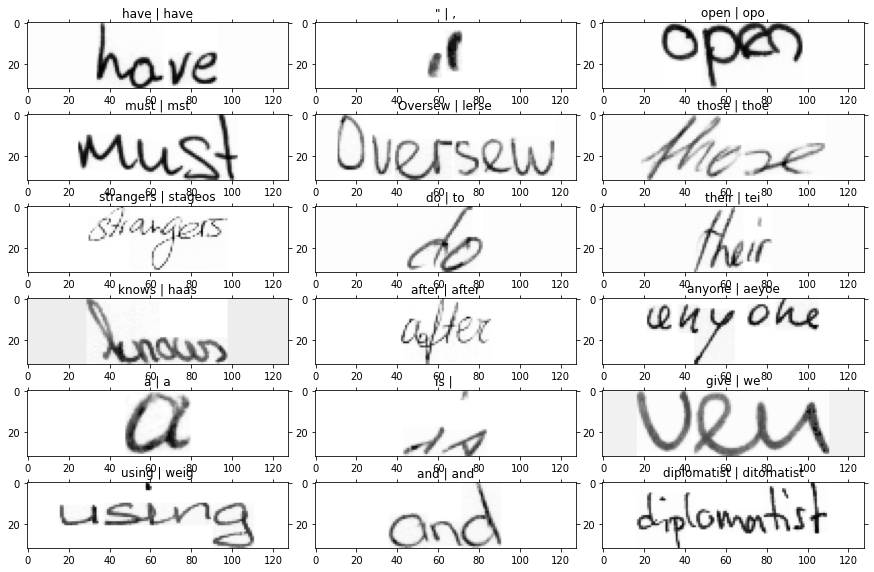

In [46]:
predictions = decode(output.softmax().topk(axis=2).asnumpy())
labels = decode(label.asnumpy())
plot_predictions(data, predictions, labels)

### Manual Testing

In [47]:
image_path = "/content/a06-025-00-00.png"

In [48]:
image = pre_processing(image_path).astype(np.float32)/255.
batchified_image = nd.array([np.expand_dims(image, axis=0)]*BATCH_SIZE, ctx)
output = net(batchified_image)
prediction = decode(output.softmax().topk(axis=2).asnumpy())

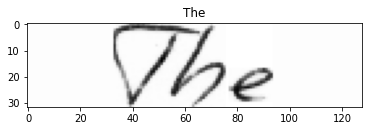

In [49]:
plt.title(prediction[0])
plt.imshow(image, cmap='Greys_r')